### Delivery Duration Prediction_ DoorDash
Task:
When a consumer places an order on DoorDash, we show the expected time of delivery. It is very important for DoorDash to get this right, as it has a big impact on consumer experience. In this exercise, you will build a model to predict the estimated time taken for a delivery and do some analysis and answer the listed questions

 - Are there particular restaurant cuisines (store_primary_category) that tend to have longer or shorter delivery times, and why? 
 - Can the model identify any patterns or relationships between the various features (e.g., total items, price, estimated order place duration, etc.) that can help explain variations in delivery duration across different orders and restaurants?


NB: for a given delivery you must predict the total delivery duration seconds , i.e., the time taken from

Start: the time consumer submits the order (created_at) to
End: when the order will be delivered to the consumer (actual_delivery_time)

In [1]:
## import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime as dt
from datetime import timedelta as td
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer 
from matplotlib import cm
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
## get the the datasets 
def get_doordash(file_name ='DoorDash_data.csv'):
    df = pd.read_csv(file_name)
    return df
df = get_doordash() 
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'DoorDash_data.csv'

In [3]:
## change cols to datetime
def to_date(col):
    col = pd.to_datetime(col)
    return col
df[['created_at', 'actual_delivery_time']]  = df[['created_at', 'actual_delivery_time']].apply(lambda x:to_date(x))

In [4]:
## Get the target variable
df['actual_delivery_duration'] = df['actual_delivery_time']-df['created_at']
df['actual_delivery_duration'] = df['actual_delivery_duration'].dt.seconds
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_delivery_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0


### Explore/Checking the data

#### Are there particular restaurant cuisines (store_primary_category) that tend to have longer or shorter delivery times, and why? 

In [5]:
## mode avergae uses while we use categorical data
store_id_unique = df["store_id"].unique().tolist()
store_id_and_category = {store_id: df[df.store_id == store_id].store_primary_category.mode()
                             for store_id in store_id_unique}
    
def fill(store_id):
    """Return primary store category from the dictionary""" 
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan
    
df["NaN_free_store_primary_category"] = df.store_id.apply(fill) 

In [6]:
df_new = df[['NaN_free_store_primary_category', 'actual_delivery_duration']]
df_new.dropna(inplace = True)
df_new.isnull().sum()

NaN_free_store_primary_category    0
actual_delivery_duration           0
dtype: int64

In [7]:
df_new.head()

,NaN_free_store_primary_category,actual_delivery_duration
0,american,3779.0
1,indian,4024.0
2,indian,1781.0
3,indian,3075.0
4,indian,2390.0


In [8]:
places = df_new.groupby('NaN_free_store_primary_category')['actual_delivery_duration'].mean().sort_values(ascending = False)
places = places.head(30)

<AxesSubplot:ylabel='NaN_free_store_primary_category'>

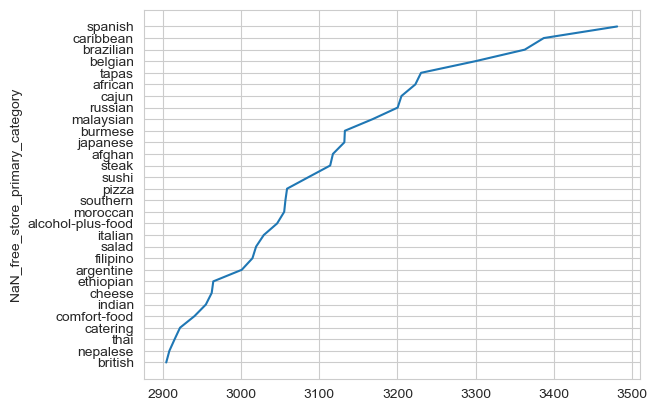

In [9]:
sns.set_style("whitegrid")
sns.lineplot(y = places.index, x = places.values)

<AxesSubplot:>

<Figure size 300x300 with 0 Axes>

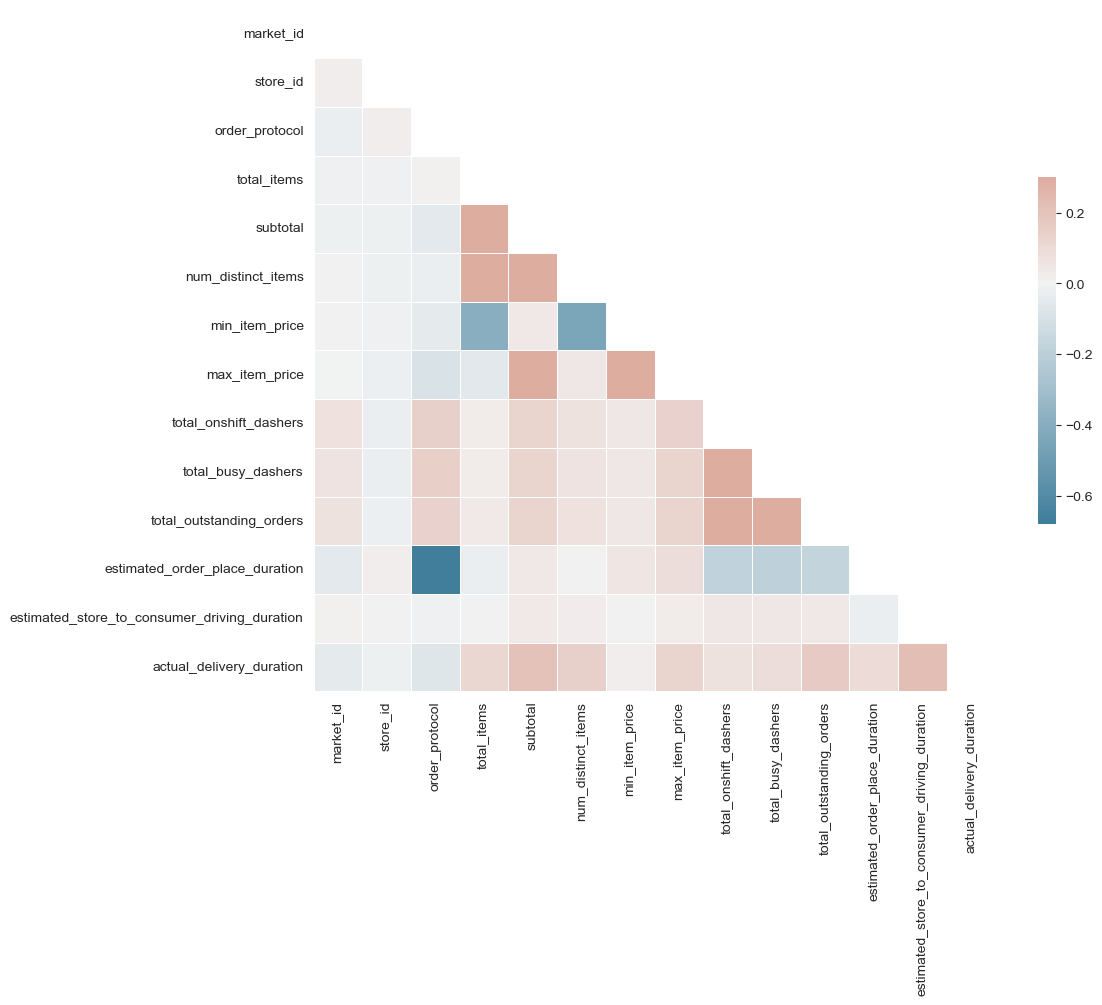

In [10]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))  # helps get the Main Diagonal elements

# Set up the matplotlib figure
fig = plt.figure(figsize = (3,3))
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
# new features/ predictive variable
df['busy_to_onshift_dasher'] = round(df['total_busy_dashers']/df['total_onshift_dashers'], 2)
df["avg_price_per_item"] = df["subtotal"] / df["total_items"]
df['range_of_prices'] = df['max_item_price'] - df['min_item_price']
df = df.drop(columns=["total_onshift_dashers", "total_busy_dashers", "subtotal", "max_item_price", "min_item_price"])

### Explore/Checking the data

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  float64       
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  int64         
 4   store_primary_category                        192668 non-null  object        
 5   order_protocol                                196433 non-null  float64       
 6   total_items                                   197428 non-null  int64         
 7   num_distinct_items                            197428 non-null  int64         
 8   total_outstanding_orders                      181166 n

In [13]:
df.isnull().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
num_distinct_items                                  0
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
actual_delivery_duration                            7
NaN_free_store_primary_category                   867
busy_to_onshift_dasher                          19838
avg_price_per_item                                  0
range_of_prices                                     0
dtype: int64

### Data transformation

In [15]:
## Add Dummies to the market_id
market_dum_id = pd.get_dummies(df['market_id'], prefix = ('market_id_'))
### Add dummies to the order category
order_dummies = pd.get_dummies(df['order_protocol'], prefix = ('order_protocol_'))
## Add dummies to the store category
store_dummies = pd.get_dummies(df["NaN_free_store_primary_category"], prefix = 'category_')

#### Drop the unncessary columns and concatinating the dummies

In [16]:
df.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items',
       'num_distinct_items', 'total_outstanding_orders',
       'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration',
       'actual_delivery_duration', 'NaN_free_store_primary_category',
       'busy_to_onshift_dasher', 'avg_price_per_item', 'range_of_prices'],
      dtype='object')

In [17]:
df1 = df.drop(columns = ['market_id', 'created_at', 'actual_delivery_time', 'store_id',
                        'store_primary_category', 'order_protocol', 'NaN_free_store_primary_category'])

df_final = pd.concat([df1, market_dum_id, order_dummies, store_dummies], axis = 1)

In [18]:
df_final['busy_to_onshift_dasher'].describe() ## how to rid of the infinity values

count    177590.00
mean           NaN
std            NaN
min           -inf
25%           0.83
50%           0.96
75%           1.00
max            inf
Name: busy_to_onshift_dasher, dtype: float64

#### Rid of the infinity valeus and Drop NaNs from all the rows

In [19]:
# check infinity values with using numpy isfinite() function
np.where(np.any(~np.isfinite(df_final),axis=0) == True) ## the non infinite values

# replace inf values with nan to drop all nans
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)

# drop NaN
df_final.dropna(how ='all', inplace=True)
df_final.shape

(197428, 96)

***


### Reduce Redundant and Collinear Features

<AxesSubplot:>

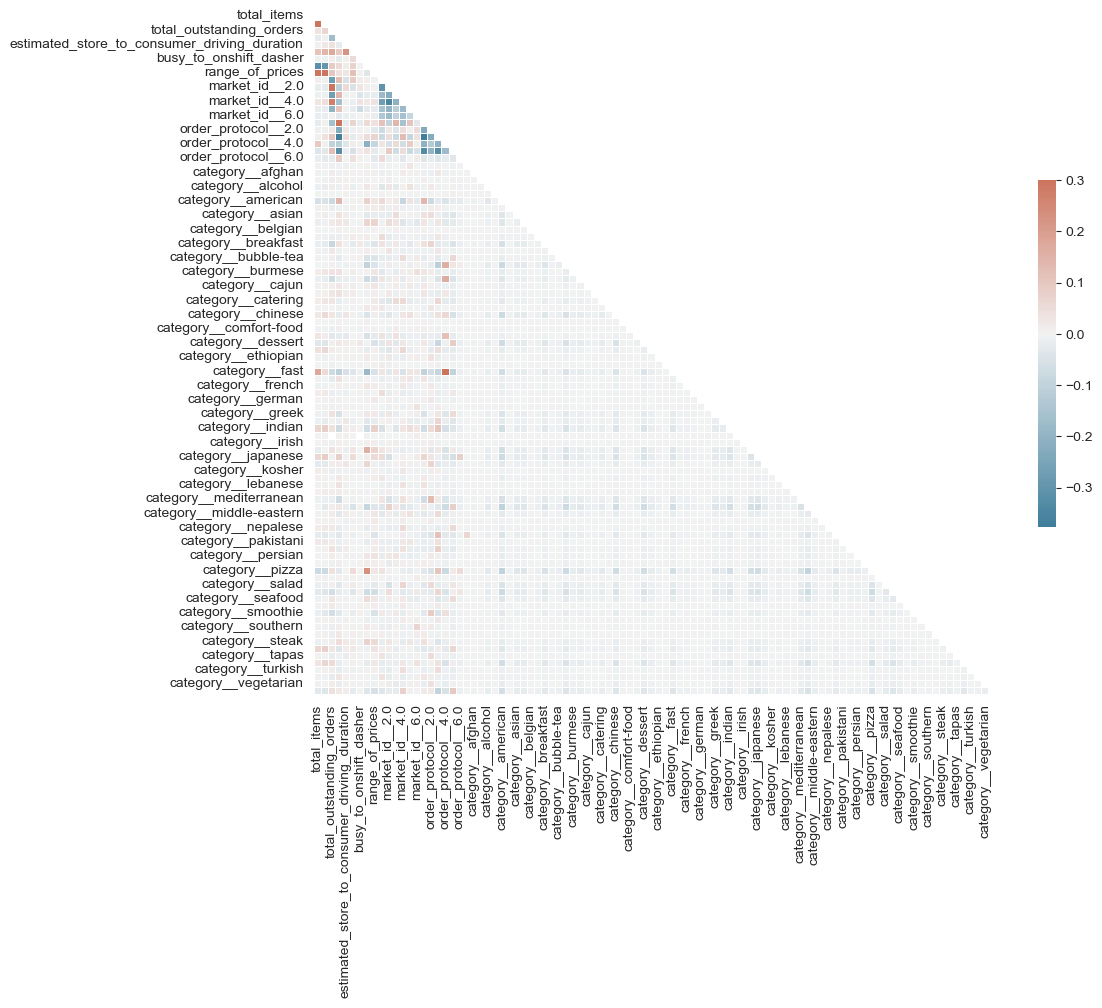

In [20]:
# it could take some time to run this cell since we are calculating correlation matrix in a dimesion of (100x100)

# Generate a mask for the upper triangle
corr = df_final.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))  # helps get the Main Diagonal elements

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [21]:
df_final['category__irish'].describe()  ## we have to drop columns with 0 values

count    197428.000000
mean          0.000268
std           0.016382
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: category__irish, dtype: float64

In [22]:
## Get diagonal and lower triangular pairs of the matrix
def get_redundant_pairs(df):  
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [23]:
## Sort correlations in the descending order and return n highest results
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df_final, 20))

Top Absolute Correlations
estimated_order_place_duration  order_protocol__1.0    0.895608
total_items                     num_distinct_items     0.763912
num_distinct_items              range_of_prices        0.499245
order_protocol__4.0             category__fast         0.496276
order_protocol__1.0             order_protocol__3.0    0.376099
estimated_order_place_duration  order_protocol__3.0    0.368385
market_id__2.0                  market_id__4.0         0.350511
total_items                     range_of_prices        0.334691
order_protocol__1.0             order_protocol__5.0    0.333033
order_protocol__3.0             order_protocol__5.0    0.326616
estimated_order_place_duration  order_protocol__5.0    0.325000
total_items                     avg_price_per_item     0.315521
market_id__1.0                  market_id__2.0         0.303789
total_outstanding_orders        market_id__2.0         0.298167
num_distinct_items              avg_price_per_item     0.293897
market_id__1.0

- From the correlation : we can see that there high correlation in the top of the list columns > need to drop them

#### Second trial : without market_id_dummies

In [24]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
df_final1 = df.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", 
                                        "NaN_free_store_primary_category", "order_protocol"])
# don't concat market id
df_final1 = pd.concat([df_final1, order_dummies , store_dummies], axis=1)
# drop highly correlated features
df_final1 = df_final1.drop(columns=["category__irish"])
# align dtype over dataset
df_final1 = df_final1.astype("float32")
# replace inf values with nan to drop all nans
df_final1.replace([np.inf, -np.inf], np.nan, inplace=True)
df_final1.dropna(inplace=True)
df_final1.head()

,total_items,num_distinct_items,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_delivery_duration,busy_to_onshift_dasher,avg_price_per_item,range_of_prices,order_protocol__1.0,...,category__southern,category__spanish,category__steak,category__sushi,category__tapas,category__thai,category__turkish,category__vegan,category__vegetarian,category__vietnamese
0,4.0,4.0,21.0,446.0,861.0,3779.0,0.42,860.25,682.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,2.0,446.0,690.0,4024.0,2.00,1900.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,446.0,690.0,1781.0,0.00,1900.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,5.0,2.0,446.0,289.0,3075.0,1.00,1150.00,1200.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3.0,9.0,446.0,650.0,2390.0,1.00,1300.00,500.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(df_final1, 20))

Top Absolute Correlations
estimated_order_place_duration                order_protocol__1.0         0.897645
total_items                                   num_distinct_items          0.758146
num_distinct_items                            range_of_prices             0.499604
order_protocol__4.0                           category__fast              0.489946
order_protocol__1.0                           order_protocol__3.0         0.373581
estimated_order_place_duration                order_protocol__3.0         0.364170
order_protocol__1.0                           order_protocol__5.0         0.342345
total_items                                   range_of_prices             0.333304
estimated_order_place_duration                order_protocol__5.0         0.333291
order_protocol__3.0                           order_protocol__5.0         0.332533
total_items                                   avg_price_per_item          0.310759
num_distinct_items                            avg_price_per_i

#### Third Trial : without order_protocol_dummies

In [26]:
### Then drop the order protocol dummies as there is a large correlation 
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol

df_final2 = df.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", 
                                        "NaN_free_store_primary_category", "order_protocol"])
# don't concat market id
df_final2 = pd.concat([df_final2, store_dummies], axis=1)
# drop highly correlated features
df_final2 = df_final2.drop(columns=["category__irish", "category__indonesian"])
# align dtype over dataset
df_final2 = df_final2.astype("float32")
# replace inf values with nan to drop all nans
df_final2.replace([np.inf, -np.inf], np.nan, inplace=True)
df_final2.dropna(inplace=True)
df_final2.head()

,total_items,num_distinct_items,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_delivery_duration,busy_to_onshift_dasher,avg_price_per_item,range_of_prices,category__afghan,...,category__southern,category__spanish,category__steak,category__sushi,category__tapas,category__thai,category__turkish,category__vegan,category__vegetarian,category__vietnamese
0,4.0,4.0,21.0,446.0,861.0,3779.0,0.42,860.25,682.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,2.0,446.0,690.0,4024.0,2.00,1900.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,446.0,690.0,1781.0,0.00,1900.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,5.0,2.0,446.0,289.0,3075.0,1.00,1150.00,1200.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3.0,9.0,446.0,650.0,2390.0,1.00,1300.00,500.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(df_final2, 20))

Top Absolute Correlations
total_items                                   num_distinct_items                0.758146
num_distinct_items                            range_of_prices                   0.499604
total_items                                   range_of_prices                   0.333304
                                              avg_price_per_item                0.310759
num_distinct_items                            avg_price_per_item                0.289541
avg_price_per_item                            category__pizza                   0.225510
estimated_store_to_consumer_driving_duration  actual_delivery_duration          0.224065
total_outstanding_orders                      actual_delivery_duration          0.187416
avg_price_per_item                            category__fast                    0.175950
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category__fast                    0.17

In [28]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(df_final2, 20))

Top Absolute Correlations
total_items                                   num_distinct_items                0.758146
num_distinct_items                            range_of_prices                   0.499604
total_items                                   range_of_prices                   0.333304
                                              avg_price_per_item                0.310759
num_distinct_items                            avg_price_per_item                0.289541
avg_price_per_item                            category__pizza                   0.225510
estimated_store_to_consumer_driving_duration  actual_delivery_duration          0.224065
total_outstanding_orders                      actual_delivery_duration          0.187416
avg_price_per_item                            category__fast                    0.175950
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category__fast                    0.17

In [29]:
df_final2.shape  ## The unncessary columns are dropped

(177070, 81)

###  Checking Multicollinearity

-  Variance Inflation Factore (VIF) determines the strength of the correlation between the independent variables.

In [30]:
## Compute VIF score using variance_inflation_factor() function
def compute_vif(features):
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df_final2[features].values, i) for i in range(len(features))] ## or you can use len(features)
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

In [31]:
# apply VIF computation to all predicting columns: drop the target variable :
features = df_final2.drop(columns=["actual_delivery_duration"]).columns.to_list()
vif_data = compute_vif(features)
vif_data

,feature,VIF
0,category__alcohol-plus-food,1.000224
1,category__chocolate,1.000372
2,category__belgian,1.000462
3,category__russian,1.002048
4,category__gluten-free,1.002623
...,...,...
75,total_items,6.109966
76,busy_to_onshift_dasher,6.350498
77,estimated_store_to_consumer_driving_duration,7.186160
78,num_distinct_items,10.919325


In [32]:
## Drop the columns with the higher VIF score: when it is greater that 20

multicollinearity = True
while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print("I will remove", highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data.VIF > 20]) == 0 else True

selected_features = vif_data['feature'].values.tolist()
vif_data 

I will remove estimated_order_place_duration


,feature,VIF
0,category__alcohol-plus-food,1.000187
1,category__belgian,1.000202
2,category__chocolate,1.000251
3,category__russian,1.001379
4,category__gluten-free,1.001444
...,...,...
74,avg_price_per_item,5.989006
75,total_items,6.109840
76,busy_to_onshift_dasher,6.349345
77,estimated_store_to_consumer_driving_duration,7.184786


### Feature selection 

#### Can the model identify any patterns or relationships between the various features (e.g., total items, price, estimated order place duration, etc.) that can help explain variations in delivery duration across different orders and restaurants?

In [33]:
# selected features are selected in multicollinearity check part
X = df_final2[selected_features]
y = df_final2["actual_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

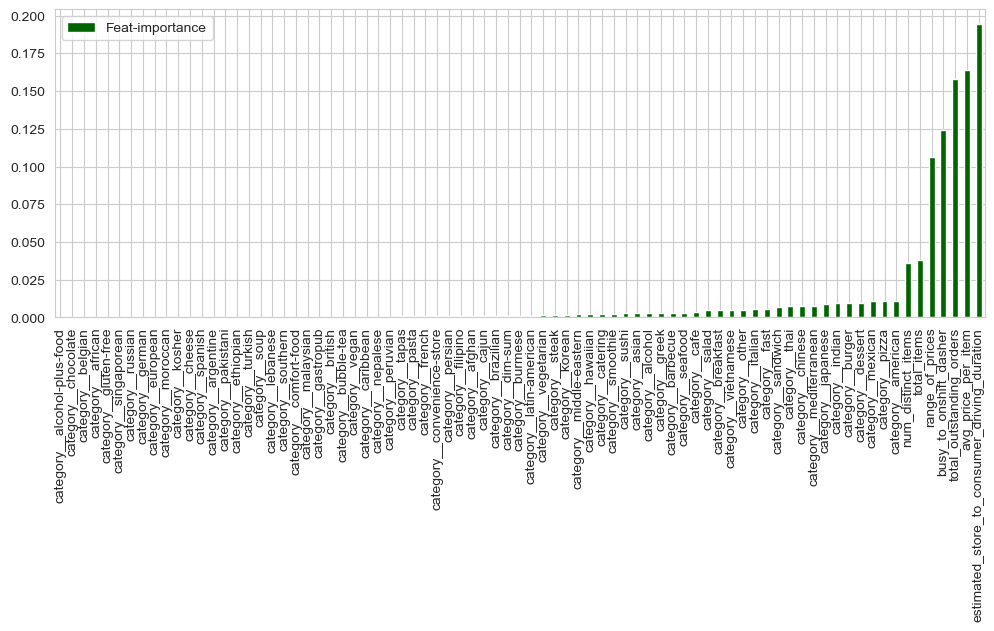

In [34]:
feature_names = [f"feature {i}" for i in range((X.shape[1]))] ## there are many things that we 
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
feat_dic = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, forest.feature_importances_):
    feat_dic[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feat_dic, orient='index').rename(columns={0: 'Feat-importance'})
importances.sort_values(by='Feat-importance').plot(kind='bar', rot=90, figsize=(12,4), color = 'darkgreen')
plt.show()

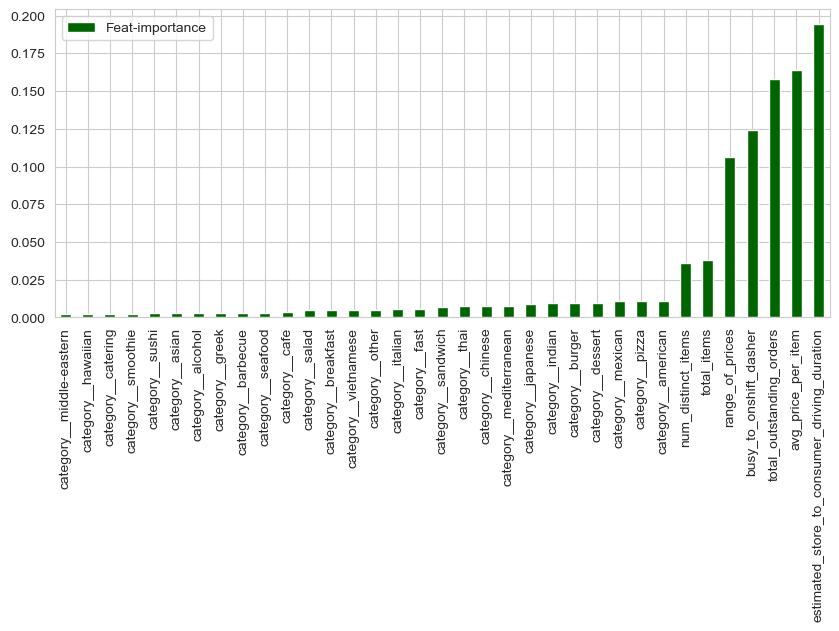

In [35]:
# check the most important ones
importances.sort_values(by='Feat-importance')[-35:].plot( kind='bar', rot=90, figsize=(10,4) ,color = 'darkgreen')
plt.show()

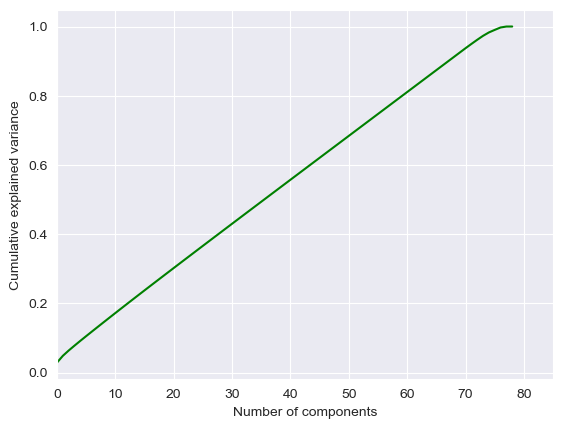

In [36]:
# apply PCA to see feature contributions
X_Train = X_train.values
X_Train = np.asarray(X_Train)

# Finding normalised array of X_Train
X_std=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
sns.set_style('darkgrid')
plt.plot(np.cumsum(pca.explained_variance_ratio_), color = 'green')
plt.xlim(0,85)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

- PCA shows that we need to use at least 60 representative features to explain 80% of the dataset, which makes the PCA transformation useless since we already have 80 and could select the most important ones based on feature importance. However, if PCA would tell us it can explain the majority of variance with around 10 features - high reduction - we would continue with it.

### Scaling

In [37]:
## Apply the selected scaler to features and target variables
def scale(scaler, X, y):
    X_scaler = scaler
    X_scaler.fit(X = X , y = y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1, 1))
    y_scaled = y_scaler.transform(y.values.reshape(-1, 1))
    
    return X_scaled, y_scaled, X_scaler, y_scaler

In [38]:
### scaling out predictive and target variable
X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, y)

# train-test split after scaling
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42)

### Inverse Transform for Metric Comparison


- Since we applied a scaler to training data, the predictions for test data will also be scaled. And to see the error in terms of seconds, we need to apply the inverse transformation. We will use Root Mean Squared Error to measure error. We could also use Mean Squared Error or Mean Absolute Error. We gave our decision based on the sensitivity of RMSE for high error terms. In out perception we are assuming, the consumer patience with delaying delivery could decrease exponentially with time

In [39]:
def rmse_with_inv_transf(scaler, y_test, y_pred_scaled, model_name):
    ### convert the scaled error to real error by inverse_transforming 
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)) 
    ## get the rmse without squaring
    rmse_error = mean_squared_error(y_test, y_predict[:, 0], squared = False)
    print(f' Error: "''{}'.format(rmse_error)+" in " + model_name)
    return rmse_error, y_predict

### Machine Learning

In [40]:
# create a generic function: that works with multiple ML models
def make_regression(X_train, y_train, X_test, y_test, model, model_name, all_good = False):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_train)
    train_err = mean_squared_error(y_train, y_predict, squared = False)
    y_predict = model.predict(X_test)
    test_err =  mean_squared_error(y_test, y_predict, squared = False)
    if all_good:
        print("Train error =" '{}'.format(train_err) + " in " + model_name)
        print("Test error ="'{}'.format(test_err) + " in " + model_name)
    trained_model = model
    
    return trained_model, y_predict, train_err, test_err


In [41]:
#from xgboost import XGBregressor
#from lightgbm import LGBMregressor
#from sklearn.neutral_networking import MLPRegressor
from sklearn import tree
from sklearn import neighbors
from sklearn import linear_model

In [42]:
pred_dict = {
    "Regression_model":[],
    "Feature_set":[],
    "Scaler_name":[],
    "RMSE":[]
}

regression_models = {
    "Ridge": linear_model.Ridge(),
    "Decision_tree": tree.DecisionTreeRegressor(max_depth = 6),
    "Random_forest": RandomForestRegressor()
}

feature_sets = {
    "whole_set":X.columns.tolist(),
    "selected_feat_40":importances.sort_values(by = 'Feat-importance')[-40:].index.tolist(),
    "selected_feat_20":importances.sort_values(by = 'Feat-importance')[-20:].index.tolist()
}

scaler = {
    "Standard_scalar": StandardScaler(),
    "MinMax_scalar": MinMaxScaler(),
    "No_scaling" : None
}

In [43]:
### exploring the errors in each model
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scaler.keys():
        print(f"------Scaled with {scaler_name} ------included features are {feature_set_name}")
        for model_name in regression_models.keys():
            if scaler_name == 'No_scaling':
                X = df_final2[feature_set]
                y = df_final2['actual_delivery_duration']
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
                make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, all_good =True)
            else:
            
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scaler[scaler_name], X[feature_set], y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, all_good=False)
                rmse_error, y_predict = rmse_with_inv_transf(y_scaler, y_test, y_predict_scaled, model_name)
                          
           
                
            pred_dict["Regression_model"].append(model_name)
            pred_dict["Feature_set"].append(feature_set_name)
            pred_dict["Scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

------Scaled with Standard_scalar ------included features are whole_set
 Error: "1147.12255859375 in Ridge
 Error: "1147.1599099176187 in Decision_tree
 Error: "1146.822436245734 in Random_forest
------Scaled with MinMax_scalar ------included features are whole_set
 Error: "1147.206298828125 in Ridge
 Error: "1147.1599096656478 in Decision_tree
 Error: "1146.855311703357 in Random_forest
------Scaled with No_scaling ------included features are whole_set
Train error =1078.8773193359375 in Ridge
Test error =1147.114990234375 in Ridge
Train error =1073.092903542184 in Decision_tree
Test error =1147.1599100050832 in Decision_tree
Train error =401.45285794631013 in Random_forest
Test error =1143.6449954411228 in Random_forest
------Scaled with Standard_scalar ------included features are selected_feat_40
 Error: "1147.955322265625 in Ridge
 Error: "1147.0636020224683 in Decision_tree
 Error: "1143.7878935081103 in Random_forest
------Scaled with MinMax_scalar ------included features are sele

### Overvew of our Models

In [44]:
### over view how models predicted
pred_df = pd.DataFrame(pred_dict)
pred_df.head()

,Regression_model,Feature_set,Scaler_name,RMSE
0,Ridge,whole_set,Standard_scalar,1147.122559
1,Decision_tree,whole_set,Standard_scalar,1147.159910
2,Random_forest,whole_set,Standard_scalar,1146.822436
3,Ridge,whole_set,MinMax_scalar,1147.206299
4,Decision_tree,whole_set,MinMax_scalar,1147.159910


<AxesSubplot:>

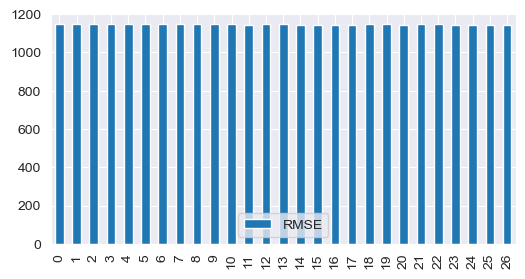

In [45]:
pred_df.plot(kind='bar', figsize=(6,3))

#### Findings

- It seems we have high errors through all models
- Models inform us to not scale affects the performance.
- We could pick one of the scalers and continue since it doesn't affect the performance much. 
- The decrease in training feature size first slightly improves the performance and then marginally made it worse. 
- We choose to use 40 as a final decision. 
- When we examine the model performances, the most significant thing is the error rates. 

In [49]:
st_s = pred_df[pred_df['Scaler_name'] == 'Standard_scalar']
Feat_40_stan_sc = st_s[st_s['Feature_set'] == 'selected_feat_40']
Feat_40_stan_sc

,Regression_model,Feature_set,Scaler_name,RMSE
9,Ridge,selected_feat_40,Standard_scalar,1147.955322
10,Decision_tree,selected_feat_40,Standard_scalar,1147.063602
11,Random_forest,selected_feat_40,Standard_scalar,1143.787894


- From the findings --> RandomForest got the best result. Then we peoceed with that model

####  Random Forest model

In [47]:
pred_dict = {
    "Regression_model":[],
    "Feature_set":[],
    "Scaler_name":[],
    "RMSE":[]
}
regression_models = {
    "Random_forest": RandomForestRegressor(),
}
feature_sets = {
    "selected_feat_40":importances.sort_values(by = 'Feat-importance')[-40:].index.tolist(),   
}
scaler = {
    "Standard_scalar": StandardScaler(),
}

In [48]:
### exploring the errors in each model
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scaler.keys():
        print(f"------Scaled with {scaler_name} ------included features are {feature_set_name}")
        for model_name in regression_models.keys():
            X = df_final2[feature_set]
            y = df_final2['actual_delivery_duration']
            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scaler[scaler_name], X, y)
            
            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, all_good=False)
            rmse_error, y_predict = rmse_with_inv_transf(y_scaler, y_test, y_predict_scaled, model_name)
            
            pred_dict["Regression_model"].append(model_name)
            pred_dict["Feature_set"].append(feature_set_name)
            pred_dict["Scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

------Scaled with Standard_scalar ------included features are selected_feat_40
 Error: "1144.3139314809023 in Random_forest


In [71]:
y_test = np.array(y_test)
df = pd.DataFrame({'True Labels': y_test, 'Predicted Labels': pd.Series(np.ravel(y_predict))})
df.head()

,True Labels,Predicted Labels
0,2448.0,2440.639996
1,1839.0,3000.350007
2,1927.0,3208.280005
3,2657.0,2042.150000
4,3596.0,2940.540002
